In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from scipy.stats import norm

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [3]:
import sys

sys.path.append('/home/ewout/enem_atp/')
from util import load_sample, load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep, scalecalparams
%load_ext autoreload
%autoreload 2

# Como funciona a TRI
A teoria de resposta ao item (TRI) √© uma metodologia para calcular notas a partir de padr√µes de respostas a "itens" (quest√µes). Ao inv√©s de simplesmente somar o n√∫mero de acertos, o c√°lculo da nota pela TRI usa todo o padr√£o de resposta do candidato, levando em conta as caracter√≠sticas das quest√µes (dificuldade, poder de "discrimina√ß√£o"). Assim, como veremos abaixo, candidatos com o mesmo n√∫mero de acertos podem ter notas completamente diferentes, dependendo de *quais* quest√µes acertaram, n√£o somente o n√∫mero delas. 

Por um lado, a metodologia TRI tem vantagens, o principal delas sendo o fato que as notas calculadas pela TRI podem ser comparadas entre edi√ß√µes da prova, por exemplo em anos diferentes. √â por esta raz√£o que avalia√ß√µes educacionais como o SAEB, o sistema que monitora o desempenho de alunos do ensino b√°sico, usa TRI. Mas por outro lado, h√° a grande desvantagem que o c√°lculo da nota pela TRI √© um processo opaco para o candidato. Como explicar a algu√©m com 10 acertos que ele recebeu, digamos, 400 pontos e um outro candidato recebeu 520 pontos?

Com um pouco de esfor√ßo, √© poss√≠ve abrir a caixa opaca da TRI. √â poss√≠vel reproduzir as notas do ENEM usando as padr√µes de resposta dos candidatos. Vamos come√ßar mostrando os dados que temoss, carregando uma amostra de alguns dos milh√µes de candidatos que fizeram a prova de 2023.

```{admonition} Microdados
Para este projeto baixamos [os microdados do ENEM](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados) disponibilizados pelo INEP. Para ver o nosso *pipeline* de processamento de dados e as fun√ß√µes que usamos abaixo, veja o nosso reposit√≥rio de c√≥digo: https://github.com/atp/enem
```


In [4]:
load_sample(2023,5)

NU_INSCRICAO  NU_ANO  TP_FAIXA_ETARIA TP_SEXO  TP_ESTADO_CIVIL  \
6193   210058931701    2023                7       M                1   
4581   210058534240    2023                6       F                1   
18268  210061780762    2023                4       M                1   
20066  210061370913    2023               11       M                1   
1077   210059457862    2023               11       F                1   

       TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  \
6193             3                 1                1                4   
4581             3                 1                1                3   
18268            3                 1                1                1   
20066            4                 1                1                6   
1077             3                 1                1                8   

       TP_ESCOLA  ...  Q016  Q017  Q018 Q019  Q020 Q021  Q022  Q023  Q024  \
6193           1  ...     A     A     A    B     A    A     C     A     B   
4581           1  ...     A     A     A    B     A    A     C     A     B   
18268          1  ...     A     A     A    B     A    A     C     A     B   
20066          1  ...     A     A     A    B     A    A     B     A     B   
1077           1  ...     A     A     A    B     A    A     C     A     A   

       Q025  
6193      B  
4581      B  
18268     B  
20066     B  
1077      B  

[5 rows x 76 columns]

Vemos que para cada candidato h√° informa√ßoes contextuais (autoreportado, na hora de fazer a inscri√ß√£o do ENEM) sobre idade, sexo, cor/ra√ßa e outros vari√°veis. Nesta base tamb√©m constam os padr√µes de resposta e a nota ENEM determinado pelo INEP. Transformamos estes dados numa outra tabela para facilitar as an√°lises que vamos fazer:

In [5]:
load_acertos(2023,'CN',5)

40724  60332  126604  117631  43890  85436  26042  83558  64023  \
candidato                                                                       
210058820269      1      0       1       0      0      0      0      0      1   
210058181078      1      0       0       0      1      0      0      0      0   
210058199003      1      0       0       0      0      0      0      0      1   
210058708198      1      0       1       0      0      1      0      0      0   
210058056073      0      0       1       1      1      0      0      0      0   

              87989  ...  111665  84422  83378  117887  66330  48492  63155  \
candidato            ...                                                      
210058820269      0  ...       0      0      1       1      0      1      1   
210058181078      0  ...       0      0      0       0      0      0      0   
210058199003      1  ...       1      1      1       1      0      0      0   
210058708198      0  ...       1      0      1       1      0      0      0   
210058056073      0  ...       0      1      1       1      0      0      0   

              acertos  caderno  nota_inep  
candidato                                  
210058820269       14     1223      534.2  
210058181078        6     1224      366.3  
210058199003       10     1223      518.1  
210058708198       10     1221      521.9  
210058056073       13     1223      537.1  

[5 rows x 48 columns]

Com os dados neste formato, podemos reproduzir as notas dadas pela INEP. Vamos transformar os 45 acertos e erros, ou "0"s e "1"s dos candidatos, em notas calculadas pelo TRI, usando os par√¢metros das quest√µes (itens, no jarg√£o das especialistas em avalia√ß√£o) fornecido pelo INEP. O resultado vai ser uma nota na "escala ENEM", que varia na pr√°tica entre 300 e 800 ou 900.

```{admonition} Interpreta√ß√£o da escala ENEM
Uma das interpreta√ß√µes equivocadas da escala ENEM mais comuns √© equiparar as notas, ainda implicitamente, a uma nota escolar do 0 at√© 10. Por√©m, n√£o √© correto interpretar 600 ou 700 na escala ENEM como sendo "mais ou menos satisfat√≥ria", como far√≠amos com notas escolares. Ao vez disso, a interpreta√ß√£o correta √© que 500 √© a m√©dia da popula√ß√£o refer√™ncia (alunos no final do ensino m√©dio em 2009) e 100 pontos na escala ENEM corresponde a um desvio padr√£o da popula√ß√£o de refer√™ncia. Assim, uma nota acima de 700 na escala ENEM seria atingido por somente 2,5% da popula√ß√£o de refer√™ncia. 
```

## A nota TRI √© bem diferente do que o n√∫mero de acertos
Antes de mostrar como notas s√£o calculadas na escala ENEM, mostramos o que todo mundo que j√° fez o ENEM sabe: dois candidatos com o mesmo n√∫mero de acertos podem ter notas ENEM bem diferentes. N√£o √© somente o n√∫mero de acertos que conta, √© tamb√©m o padr√£o de respostas que √© levado em conta:

<Axes: xlabel='acertos', ylabel='nota_inep'>

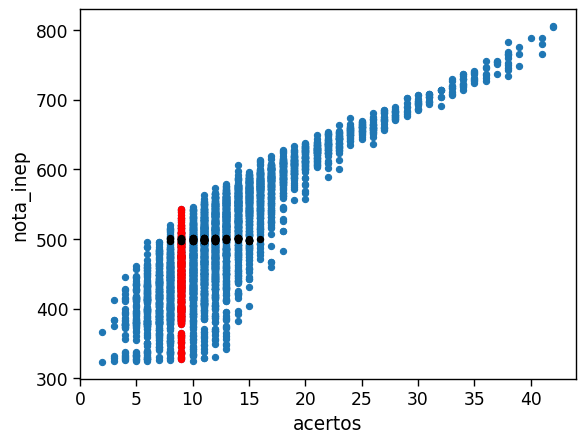

In [124]:
ano = 2023
area = 'CN'
df = load_acertos(ano,area,5000)
ax = df.plot(kind='scatter',x='acertos',y='nota_inep')
df.query("acertos == 9").plot(kind='scatter',x='acertos',y='nota_inep', color='r',ax=ax)
df.query("nota_inep > 497 & nota_inep < 502").plot(kind='scatter',x='acertos',y='nota_inep', color='k',ax=ax)

Vemos que para pessoas com 9 acertos a nota ENEM pode variar de 330 at√© 530, dependendo quais quest√µes acertaram. E, para quem tirou uma nota ENEM de 500, o n√∫mero de acertos pode ter sido entre 9 e 16.

## O "peso" da quest√£o n√£o √© sua dificuldade

O que explica esta diferen√ßa √© o padr√£o de respostas dos candidatos. De uma forma geral, quem acerta de forma mais consistente ganha uma nota maior. Mas, contr√°rio ao senso comum, n√£o √© verdade que quest√µes mais dif√≠ceis "pesam mais" e levam a uma nota maior. Talvez surpreendentemente, dado um certo n√∫mero de acertos, √© melhor acertar itens f√°ceis do que acertar itens dif√≠cil. Podemos mostrar isso com candidatos reais.

O INEP fornece os par√¢metros dos itens, as caracter√≠sticas das quest√µes determinadas durante o processo de testagem. O par√¢metro $a$ representa a "discrimina√ß√£o" do item, $b$ √© a dificuldade e $c$ a probabilidade de acerto por acaso. Mais abaixo explicamaremos melhor como interpretar estes par√¢metros. Agora vamos mostrar que o par√¢metro `b` *n√£o* deve ser interpretado como o "peso" da quest√£o. 

In [125]:
params = params_inep(ano, area)
params[:5]

a_inep  b_inep  c_inep  u
CO_ITEM                           
64023      1.81    1.42    0.25  1
97149      0.99    1.56    0.20  1
84041      3.68    1.27    0.10  1
66259      2.34    1.00    0.24  1
117866     2.34    1.77    0.11  1

Com algumas manobras, podemos mostrar a diferen√ßa entre as padr√µes de resposta de dois candidatos com o mesmo n√∫mero de acertos. Observe que a nota alta √© obtida para quem acerto as quest√µes mais f√°ceis. O padr√£o com acertos em itens dif√≠ceis mas erros em itens f√°ceis √© pouco prov√°vel e o algoritmo TRI associa uma nota baixa. 

In [127]:
itens_a = pd.qcut(params['a_inep'],3,labels=['Baixa','M√©dia','Alta'])
itens_b = pd.qcut(params['b_inep'],3,labels=['Baixa','M√©dia','Alta'])
itens = pd.concat([itens_a,itens_b],axis=1)
itens.columns = ['discrimina√ß√£o','dificuldade']

def compare_padr(nacertos=9):
    padrmin = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmin()]
    padrmax = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmax()]
    notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
    padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
    padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
    result = params.join(itens).join(padrmin).join(padrmax)
    result.columns = ['a','b','c','u','discrimina√ß√£o','dificuldade','nota_baixa','nota_alta']
    result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
    result.columns = ['a','b','c','u','discrimina√ß√£o','dificuldade',f'nota = {notamin}',f'nota = {notamax}']
    return result

iw = widgets.IntText(
    value=9,
    description='Acertos:',
)
interact(compare_padr, nacertos=iw);

interactive(children=(IntText(value=9, description='Acertos:'), Output()), _dom_classes=('widget-interact',))

Podemos tamb√©m comparar dois candidatos com notas parecidas do ENEM. Vemos na figura acima que candidatos com uma nota de 500 podem ter acertado entre 6 e 15 itens. Qual √© a diferen√ßa entre os padr√µes de resposta deste dois candidatos?

Veja abaixo como o padr√£o de resposta √© diferente para dois candidatos com essencialmente a mesma nota ENEM. O primeiro, com poucos acertos, acertou quase todas as quest√µes f√°ceis. O segundo tamb√©m acertou uma fra√ß√£o das quest√µes f√°ceis, mas errou alguns. Apesar de ter acertadas itens dif√≠ceis, n√£o adiantou. Acertar uma quest√£o dif√≠cil sem acertar as f√°ceis n√£o leva a notas maiores no TRI. 

In [128]:
nota1, nota2 = 499,501
dfn = df.query("nota_inep <= @nota2 and nota_inep > @nota1")
padrmin = dfn.loc[dfn['acertos'].idxmin()]
padrmax = dfn.loc[dfn['acertos'].idxmax()]
notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
acertosmin,acertosmax = padrmin['acertos'], padrmax['acertos']
padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
padrmin.index = padrmin.index.astype(str);padrmax.index = padrmax.index.astype(str)
result = params.join(itens).join(padrmin).join(padrmax)
result.columns = ['a','b','c','u','discrimina√ß√£o','dificuldade','nota_baixa','nota_alta']
result = result.sort_values(['b'],ascending=True).query("nota_baixa == 1 or nota_alta == 1")
result.columns = ['a','b','c','u','discrimina√ß√£o','dificuldade',f'acertos: {acertosmin}, nota: {notamin}',f'acertos: {acertosmax}, nota = {notamax}']
result = result.drop(columns=['a','b','c','u'])
result

discrimina√ß√£o dificuldade  acertos: 8.0, nota: 499.7  \
CO_ITEM                                                        
83378           Baixa       Baixa                       1.00   
40724           Baixa       Baixa                       1.00   
126604           Alta       Baixa                       1.00   
117887          M√©dia       Baixa                       0.00   
117631          Baixa       Baixa                       1.00   
141723          M√©dia       Baixa                       1.00   
83558           Baixa       Baixa                       0.00   
66259           M√©dia       Baixa                       0.00   
111665           Alta       Baixa                       0.00   
63155            Alta       M√©dia                       0.00   
64023           Baixa       M√©dia                       0.00   
60689            Alta       M√©dia                       0.00   
48641            Alta       M√©dia                       0.00   
97149           Baixa       M√©dia                       1.00   
60332            Alta       M√©dia                       1.00   
83552           M√©dia       M√©dia                       0.00   
85436           Baixa       M√©dia                       0.00   
60037           M√©dia        Alta                       0.00   
12018           Baixa        Alta                       0.00   
97767           Baixa        Alta                       0.00   
54162           Baixa        Alta                       1.00   

         acertos: 16.0, nota = 499.7  
CO_ITEM                               
83378                           0.00  
40724                           1.00  
126604                          0.00  
117887                          1.00  
117631                          0.00  
141723                          1.00  
83558                           1.00  
66259                           1.00  
111665                          1.00  
63155                           1.00  
64023                           1.00  
60689                           1.00  
48641                           1.00  
97149                           0.00  
60332                           1.00  
83552                           1.00  
85436                           1.00  
60037                           1.00  
12018                           1.00  
97767                           1.00  
54162                           0.00

## O modelo TRI determina a probabilidade dos padr√µes de resposta
A teoria de resposta ao item faz uma modelagem probabil√≠stica para as respostas de um candidato √†s quest√µes da prova. Vamos chamar a habilidade (presuposto uma quantidade unidimensional nos modelos simples) $\theta$ e os padr√µes de resposta $x_i = 0$ (errou) ou $1$ (acertou) para $i=1\ldots 45$. Ent√£o o model TRI postula que um candidato com habilidade $\theta$ tem uma certa probabilidade $P_i(x_i = 1|\theta;a_i,b_i,c_i)$ que o candidato acertar a quest√£o $i$. √â esta "habilidade" $\theta$ que vai virar a nota do ENEM.

Vemos que a probabilidade de acertar depende da habilidade do candidato e das caracter√≠sticas das quest√µes (parametrizado acima com tr√™s par√¢metros, mas pode haver outros modelos para as caracter√≠sticas das quest√µes). Qualquer modelo razo√°vel vai dar uma probabilidade maior de acerto para habilidades $\theta$ maiores. Da mesma forma, a probabilidade de acerto deve diminuir para quest√µes mais dif√≠ceis (para uma determinada habilidade fixa). Grande parte do problema t√©cnica da TRI √© estimar, baseado em muitas padr√µes de resposta a provas como estas que vimos acima, as caracter√≠sticas das quest√µes. Por agora vamos supor que esta calibra√ß√£o das caracter√≠sticas das quest√µes foi feito e que conhecemos os par√¢metros das quest√µes e portanto a fun√ß√£o $P_i$. Agora vamos se perguntar: dado uma certa habilidade, quais ser√£o as padr√µes de resposta mais prov√°veis? Uma vez que temos um modelo para esta pergunta, vamos inverter a quest√£o e perguntar: dado um certo padr√£o de resposta, qual √© a habilidade correspondente mais prov√°vel?

A probabilidade de um determinado padr√£o de respostas $\{x_1, x_2 \ldots x_{45}\} = \{x_i\} = \vec{x}$, dado uma certa habilidade √©

$$ \text{prob}(\vec{x}|\theta)= \prod_{i=1}^{45} P_i(\theta)^{x_i} (1-P_i(\theta))^{1-x_{i}} $$

Isso parece uma express√£o complicada, mas √© poss√≠vel de entender. Estamos supondo que as probabilidades de acertar quest√µes s√£o todas independentes. Neste caso, as leis da probabilidade dizem que precisamos multiplicar as probabilidades de acerto para todas as 45 quest√µes da prova. Vamos supor que queremos saber a probabilidade de um determinado padr√£o de resposta, digamos $\{0,1,1,0\ldots\}$. A probabilidade de *errar* a primeira quest√£o √© $(1-P_1)$, a probabilidade de *acertar* a segunda quest√£o √© $P_2$, a terceira $P_3$, a de *errar* a quarta $(1-P_4)$, e assim at√© a √∫ltima quest√£o e precisamos multiplicar todas estas probabilidades. Observe que os expoentes $P_i^{x_1}$ na expressao acima √© s√≥ nota√ß√£o que escolha $P$ para um acerto ($x_i = 1)$ e $(1-P)$ para um erro ($x_i = 0)$. 

A express√£o acima para as $2^{45}$ probabilidades, um para cada padr√£o de respostas poss√≠vel, √© o *modelo* da TRI. Se n√£o fixamos uma habilidade, cada probabilidade de cada padr√£o de resposta pode ser considerada uma fun√ß√£o da habilidade $\theta$. H√° duas formas de "inverter" a express√£o acima se conhecemos o padr√£o de resposta mas agora queremos saber a habilidade $\theta$. Primeiro o m√©todo tradiconal em estast√≠stica, "m√°xima verossimilhan√ßa". Segundo, o m√©todo Bayesiano.


### Estimar $\theta$ por meio do m√©todo de m√°xima verossimilhan√ßa
Para demonstrar como a infer√™ncia da habilidade $\theta$ funciona, dado um padr√£o de respostas, vamos analisar um modelo concreto. Precisamos especificar as caracter√≠sticas das quest√µes (as fun√ß√µes $P_i$) e como exemplo vamos analisar um dos $2^{45}$ padr√µes de resposta poss√≠vel: 45 cinco respostas (acertos ou erros para cada uma das quest√µes): $\{0,1,1,0\ldots\}$. 

Veja as probalidades de acerto que vamos usar (s√≥ vamos usar alguns, a t√≠tulo de exemplo):

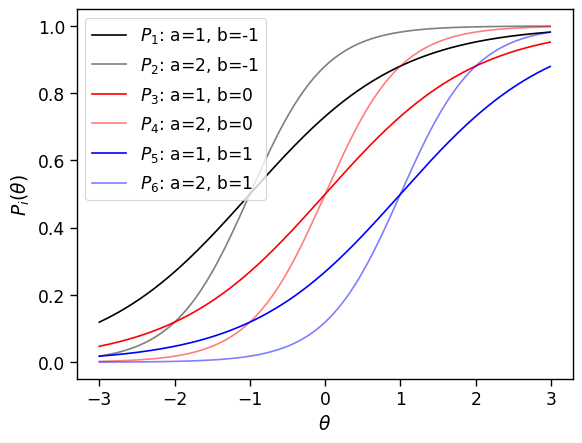

In [118]:
theta = np.arange(-3,3,0.01)
sns.set_context('paper',font_scale=1.4)
def P(theta,a=1,b=0,c=0):
    return c + (1-c)*1/(1+np.exp(a*(b-theta)))
colors = ['k','r','b'];i=0
for b in [-1,0,1]:
    for a in [1,2]:
        color = colors[i//2];i +=1
        alpha = 1/a
        sns.lineplot(x=theta,y=P(theta,a,b),color=color, alpha = alpha, label=f"$P_{i}$: a={a}, b={b}")
ax = plt.gca()
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$P_i(\theta)$");

Vamos inicialmente imaginar que s√≥ temos informa√ß√£o sobre o acerto ou erro da primeira quest√£o. No nosso exemplo, o candidato errou e $x_1 = 0$. Por enquanto, o nosso modelo diz:

$$ \text{prob}(x_1 = 0|\theta) = P_1(\theta)^{0} (1-P_1(\theta)^{1-0} = 1-P_1(\theta)$$


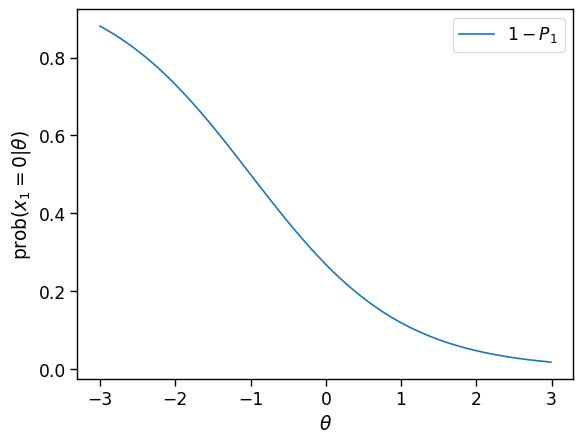

In [34]:
ax = sns.lineplot(x=theta,y=1-P(theta,a=1,b=-1), label=f"$1-P_{1}$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0|\theta)$");

N√£o d√°, ainda, para dizer muito sobre a prov√°vel habilidade. No m√©todo de "m√°xima verossimilhan√ßa" ou ML, com somente a informa√ß√£o sobre o erro na primeira quest√£o, a √∫nica coisa para dizer √© que √© mais prov√°vel que a habilidade √© baixa. Veremos abaixo que no m√©todo Bayesiano, que leva em conta mais informa√ß√£o do que somente os acertos √†s quest√µes, poder√≠amos dizer um pouco mais. Vamos √† pr√≥xima quest√£o, era um acerto: $x_2 =1$. Agora a probabilidade desta padr√£o de resposta √©

$$\text{prob}(x_1 = 0, x_2 = 0|\theta) = (1-P_1(\theta))(P_2(\theta))$$

e podemos novamente fazer um gr√°fico da probabilidade desta "padr√£o de resposta" de agora duas respostas:

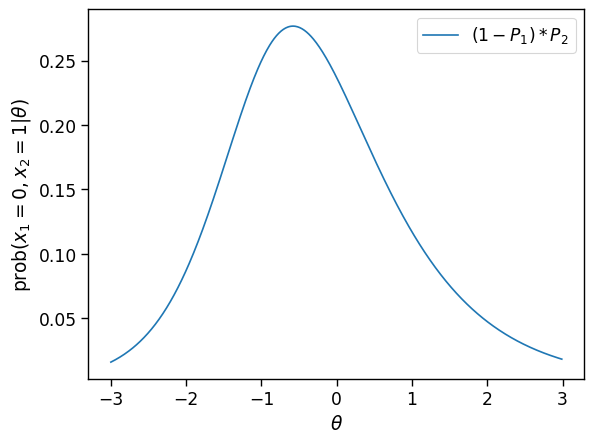

In [35]:
ax = sns.lineplot(x=theta,y=(1-P(theta,a=1,b=-1))*P(theta,a=2,b=-1), label=f"$(1-P_{1})*P_2$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1|\theta$)");

Vemos que com duas repostas, um erro e outro acerto, j√° podemos fazer infer√™ncias com um pouco mais de confian√ßa. O m√©todo de "m√°xima verossimilhan√ßa" agora estima uma habilidade pr√≥ximo de -1. Vamos, para finalizar o exemplo, analisar o padr√£o de resposta $\{0,1,1,0\}$. 

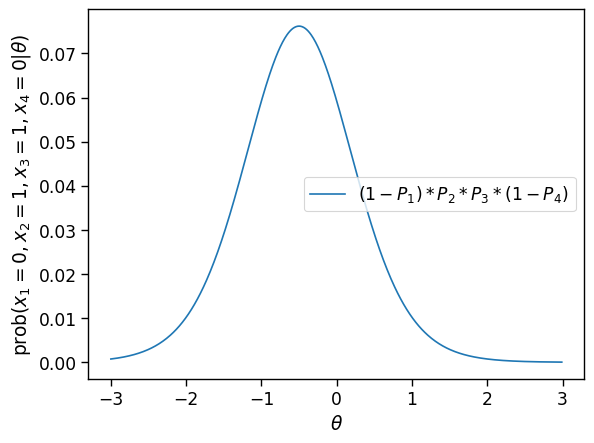

In [36]:
ax = sns.lineplot(x=theta,y=(1-P(theta,a=1,b=-1))*P(theta,a=2,b=-1)*P(theta,a=1,b=0)*(1-P(theta,a=2,b=0)), label=f"$(1-P_{1})*P_2*P_3*(1-P_4)$");
ax.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(x_1=0,x_2=1,x_3=1,x_4=0|\theta$)");

Podemos concluir 


### Estimar $\theta$ por m√©todos Bayesianos
XXX

In [114]:
areawidg = widgets.Dropdown(
    options=['CN','CH','MT'],
    value='CN',
    description='Area:',
)
anowidg = widgets.Dropdown(
    options=range(2023,2008,-1),
    value=2022,
    description='Ano:',
)
faixawdg = widgets.BoundedFloatText(
    value=1,
    min=-1.2,
    max=3,
    step=0.1,
    description='Nota:',
    disabled=False
)

def escolhe_padr(ano=2022,area='CN',faixa=0):
    padr = load_acertos(ano,area,3000,True)
    nota = 500+faixa*100
    nota_inep = padr.iloc[:,-3:]
    nota_inep = nota_inep.query("nota_inep > @nota and nota_inep < @nota + 5")
    nota_inep = nota_inep.sample(1)
    nota = nota_inep['nota_inep'].iloc[0];acertos = nota_inep['acertos'].iloc[0]
    print(f"Acertos = {acertos}, nota INEP = {nota}" )
    index = nota_inep.index[0]
    padr = padr.loc[index:index]
    params = params_inep(ano,area,dropna=True)
    score_mirt_ml = score_inep(padr,ano,area,method="ML",enemscale=False)
    nota_mirt_ml = score_mirt_ml['nota'].iloc[0]
    se_mirt_ml = score_mirt_ml['se'].iloc[0]
    score_mirt_eap = score_inep(padr,ano,area,method="EAP",enemscale=False)
    nota_mirt_eap = score_mirt_eap['nota'].iloc[0]
    se_mirt_eap = score_mirt_eap['se'].iloc[0]

    print(f"Nota ML do mirt = {nota_mirt_ml:.2f} ¬± {se_mirt_ml:.2f}")
    print(f"Nota EAP do mirt = {nota_mirt_eap:.2f} ¬± {se_mirt_eap:.2f}")
    params = params.join(padr.T)
    return params

interact(escolhe_padr,ano=anowidg,area=areawidg,faixa=faixawdg)


interactive(children=(Dropdown(description='Ano:', index=1, options=(2023, 2022, 2021, 2020, 2019, 2018, 2017,‚Ä¶

<function __main__.escolhe_padr(ano=2022, area='CN', faixa=0)>

In [121]:

def vero(ano=2022,area='CN',faixa=0,ordem_dificuldade=True,calculate_until=45):

    params = escolhe_padr(ano,area,faixa=faixa)
    params = params.sort_values('b_inep',ascending=ordem_dificuldade)
    i=0

    theta = np.arange(-3,3,0.01)
    lh = np.ones(len(theta))
    
    for item,value in params.iterrows():
    
        if i == calculate_until: 
            print(f"stopped at item {i}")
            break
        i += 1
    
        acertou = int(value.iloc[-1])
        if acertou:
            lh = lh*P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep'])
        else:
            lh = lh*(1-P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep']))

    nota_ml = (-3+lh.argmax()*0.01)
    posterior = lh*norm.pdf(theta)
    nota_eap = np.average(theta, weights=posterior)
    def check(s):
        if s: return '‚úÖ'
        else: return '‚ùå'
    params.iloc[:,-1] = params.iloc[:,-1].apply(check)
    params = params.drop(columns=['a_inep','u','c_inep'])
    params = params.transpose()
    params.insert(i,column = 'üõë',value=['|>','|>'])
    pd.options.display.float_format = '{:.2f}'.format
    pd.set_option('display.max_columns', 500)
    display(params)
    with sns.axes_style("whitegrid"):
        fig,axs = plt.subplots(1,2,sharex=True,figsize = (16,6))
        ax1 = axs[0]; ax2 = axs[1]
        sns.lineplot(x=theta,y=lh,ax=ax1);
        ax1.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(\vec{x_i}|\theta)$");
        ax1.set_title(f"M√°xima verossimilhan√ßa: nota = {nota_ml:.3f}");
        sns.lineplot(x=theta,y=posterior,ax=ax2);
        ax2.set_xlabel(r"$\theta$");ax.set_ylabel(r"Posterior");
        ax2.set_title(f"Expected a Posteriori: nota = {nota_eap:.3f}");
        
        plt.grid(axis='y')
    return


interact(vero,ordem_dificuldade=True,calculate_until=range(0,46))

interactive(children=(IntSlider(value=2022, description='ano', max=6066, min=-2022), Text(value='CN', descript‚Ä¶

<function __main__.vero(ano=2022, area='CN', faixa=0, ordem_dificuldade=True, calculate_until=45)>